In [1]:
# go up a level to import mc_processor and analyses
import sys
sys.path.append('..')
import mc_processor
import visualizing

import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

import importlib
importlib.reload(mc_processor)
importlib.reload(visualizing)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
# read results files

# clarifier = "field1/"
# clarifier = "field2/rvoter/"
clarifier = "stacked/"

codebook = pd.read_csv('raw/levels_codebook.csv', encoding='utf-8')
data = pd.read_csv(f'raw/{clarifier}data.csv', encoding='utf-8')
q_codebook = pd.read_csv('raw/question_codebook.csv', encoding='utf-8', index_col = 'qid')

# q_codebook into dict
q_codebook = q_codebook.to_dict().get('qidFull')

In [3]:
# print all demo categories
for key in q_codebook:
    if "dem" in key:
        print(key)

xdemAll
demZIP
xdemGender
demAgeGeneration
xdemIdeo3
xdemInc3
xdemWhite
xdemHispBin
demBlackBin
demRaceOther
xdemReligion
xdemReligOther
xdemEvang
xdemUsr
xdemEmploy
xdemMilHH1
xdemBidenApprove
xdemBidenApprove2
demInsured
demInsType
demUnion
demLGBTQ1
xdemMarried
BPCxdem1
BPCxdem2
BPCxdem3
BPCxdem4
BPCxdem5
demGender3
demRVoter


In [15]:
df = data[['BPCxdem2', 'xpid3']]

bpcxdem2_map = {1: 'Transgender', 2: 'Cisgender'}
xpid3_map = {1: 'D', 2: 'I', 3: 'R'}
df['BPCxdem2'] = df['BPCxdem2'].map(bpcxdem2_map)
df['xpid3'] = df['xpid3'].map(xpid3_map)

grouped_stats = df.groupby(['BPCxdem2', 'xpid3']).size().unstack(fill_value=0)
grouped_stats

#

/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_53146/2495986277.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BPCxdem2'] = df['BPCxdem2'].map(bpcxdem2_map)
/var/folders/2f/3k2b0y_s79n84y37bcnb5t5h0000gn/T/ipykernel_53146/2495986277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['xpid3'] = df['xpid3'].map(xpid3_map)


xpid3,D,I,R
BPCxdem2,,,
Cisgender,1503,860,1178
Transgender,41,26,26


In [4]:
data[["BPCxdem2"]].value_counts() # trans

BPCxdem2
2           3541
1             93
Name: count, dtype: int64

In [5]:
# mc_processor.get_confidence_results(data,codebook,q_codebook,21,demo="BPCxdem2",suppress_output=False)

## Confidence analysis

In [11]:
##CONFIDENCE RATES

#save individual csvs for confidence by xpid3
confidence_keys = {'BPC20': "Your vote", 'BPC21':"Votes in your city or county", 'BPC22':"Votes in your state", 'BPC23':"Votes across the country"}

demo = None

dfs = {}

for i in [f"BPC{j}" for j in range(20, 24)]:
    df = mc_processor.get_confidence_results(data, codebook, q_codebook, question=i, demo=demo, suppress_output=True)
    dfs[confidence_keys[i]] = df
    df = df.map(lambda x: f"{x:.1%}")
    df.to_csv(f"charts/BPC{i}_{demo}.csv")


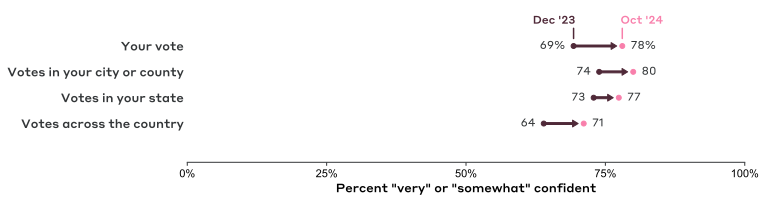

In [12]:
##PLOT OVERALL CONFIDENCE RATES
importlib.reload(visualizing)
demo = None
question_number = 20

dfs = []
cols = []
for i in [f"BPC{j}" for j in range(20,24)]:
    dfs.append(mc_processor.get_confidence_results(data,codebook,q_codebook,i,demo=None,suppress_output=True))#.map(lambda x: f"{x:.1%}"))
    cols.append(q_codebook[f"{i}a"])

confidence = pd.concat(dfs, axis=1)
confidence.columns = cols

##DOT PLOT CHANGE IN CONFIDENCE 23 -> 24

confidence2024 = confidence
confidence2023 = pd.read_csv("../2023/processed/confidence.csv",index_col=0)

# cols
confidence2023.columns = list(confidence_keys.values())
confidence2024.columns = list(confidence_keys.values())


confidence_23_24 = []
dfs= [confidence2023,confidence2024]
years  = ["2023","2024"]
for i in range(2):
    df = dfs[i].T
    df[years[i]] = df[["Very confident","Somewhat confident"]].sum(axis=1)
    df = df[[years[i]]]
    confidence_23_24.append(df)

confidence_23_24 = pd.concat(confidence_23_24,axis=1)

%config InlineBackend.figure_format = 'svg'

importlib.reload(visualizing)
visualizing.dotplot(confidence_23_24,
                     'charts/confidence_23_24.png',
                     start_tick_title = "Dec '23",
                     end_tick_title = "Oct '24",
                     xlabel='Percent "very" or "somewhat" confident',
                     title='How confident are you that _____ will be counted accurately in the 2024 election?',
                     color1=visualizing.adjust_color('#5E233B', bright_mult=0.93, sat_mult=0.7),
                     color2='#F87FAB')


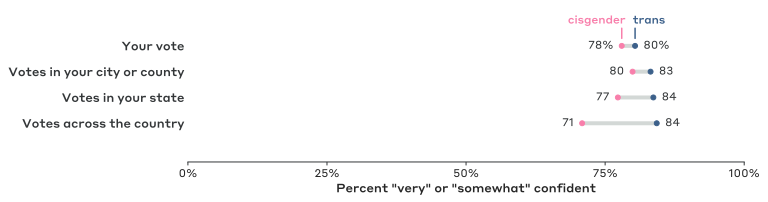

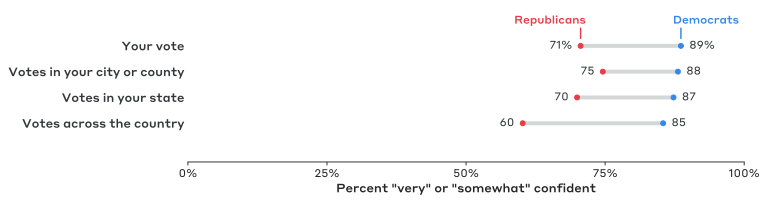

In [13]:
##PLOT CONFIDENCE RATES BY PARTY ID

tick_labels = {'BPCxdem2':['cisgender','trans'],'xpid3':['Republicans','Democrats']}

for demo in ['BPCxdem2','xpid3']:

    # demo = 'BPCxdem2' #trans 'xpid3' = party

    res = []

    for i in [f"BPC{j}" for j in range(20,24)]:
        df = mc_processor.get_confidence_results(data,codebook,q_codebook,i,demo=demo,suppress_output=True)#.map(lambda x: f"{x:.1%}")
        df = df.T
        res.append(df[["Very confident","Somewhat confident"]].sum(axis=1))

    res = pd.concat(res,axis=1)
    res.columns = confidence_keys.values()

    # modify for dotplot
    res = res.T
    if demo == 'xpid3':
        res = res.drop(["PID: Ind (no lean)","overall"],axis=1)
        
    res = res[[res.columns[1],res.columns[0]]]

    ## adjusted for BPCxdem2

    importlib.reload(visualizing)

    visualizing.dotplot(res,
                        f'charts/confidence_{demo}.png',
                        start_tick_title = tick_labels[demo][0],
                        end_tick_title = tick_labels[demo][1],
                        xlabel='Percent "very" or "somewhat" confident',
                        plot_type = "other")


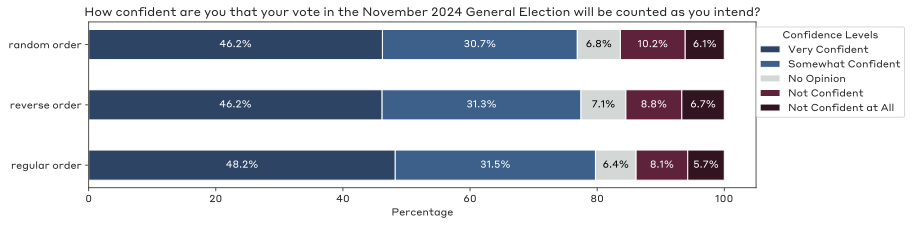

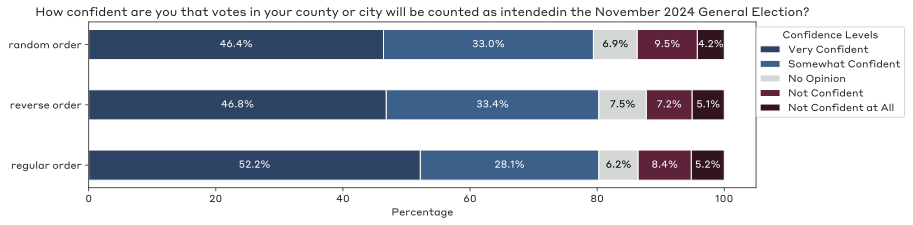

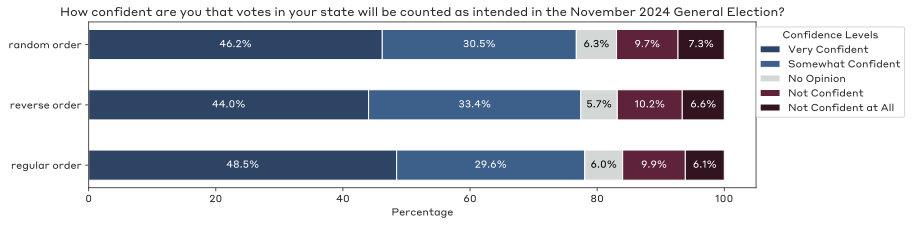

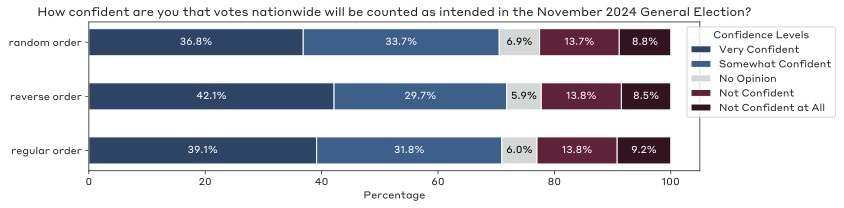

In [107]:
##PLOT CONFIDENCE SPLIT SAMPLES
#split sample a - regular order
#split sample b - reverse order
#split sample c - random order
importlib.reload(visualizing)

sample_dict = {"a":"regular order","b":"reverse order","c":"random order"}

all_dfs = []

for i in range(20,24):
    # store dfs for each sample
    q_dfs = []    
    for split_sample in ["a","b","c"]:
        question = "BPC"+str(i)+split_sample
    
        # get results for question by sample
        df = mc_processor.run_and_display(data,codebook,q_codebook,question,demo=None,suppress_output=True)
        df.columns = [f"{sample_dict[split_sample]}"]
        q_dfs.append(df)
    
    # print(q_codebook[question]) # defaults to split sample c, but tested with other a/b/c combos and got same result (they rotated question order but didn't change question #)
    
    q_df = pd.concat(q_dfs, axis=1)

    q_df["deviation"] = q_df.std(axis=1)

    ## display df with formatted percents
    # display(q_df.iloc[:,0:3].map(lambda x: f"{x:.1%}"))

    all_dfs.append(q_df)

visualizing.plot_split_sample(all_dfs, q_codebook)

# # get n for split samples
# for sample in ["a","b","c"]:
#     # for q in range(20,24):
#     q = 20
#     print(data[[f"BPC{q}{sample}"]].count())

## Run for most questions

In [10]:
# store demo results in processed folder
demos = ['xpid3','age']
questions = [f"BPC{i}" for i in range(1, 20)] + ['BPC24']

for demo in demos:
     for question in questions:
          mc_processor.run_and_display(data,codebook,q_codebook,question,demo,suppress_output=True)

In [11]:
# # save BPC2 as chart
# mc_processor.run_and_display(data,codebook,q_codebook,"BPC2",demo=None,suppress_output=False,save_fig_path="charts/BPC2.png")

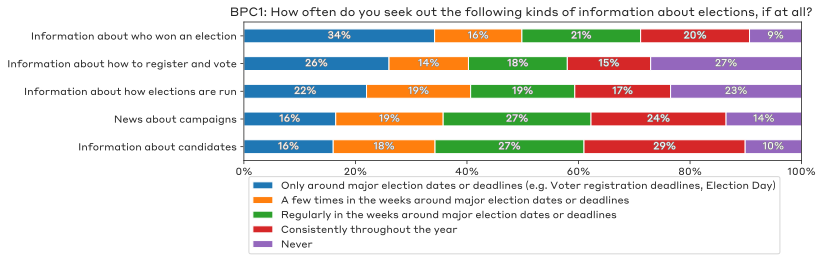

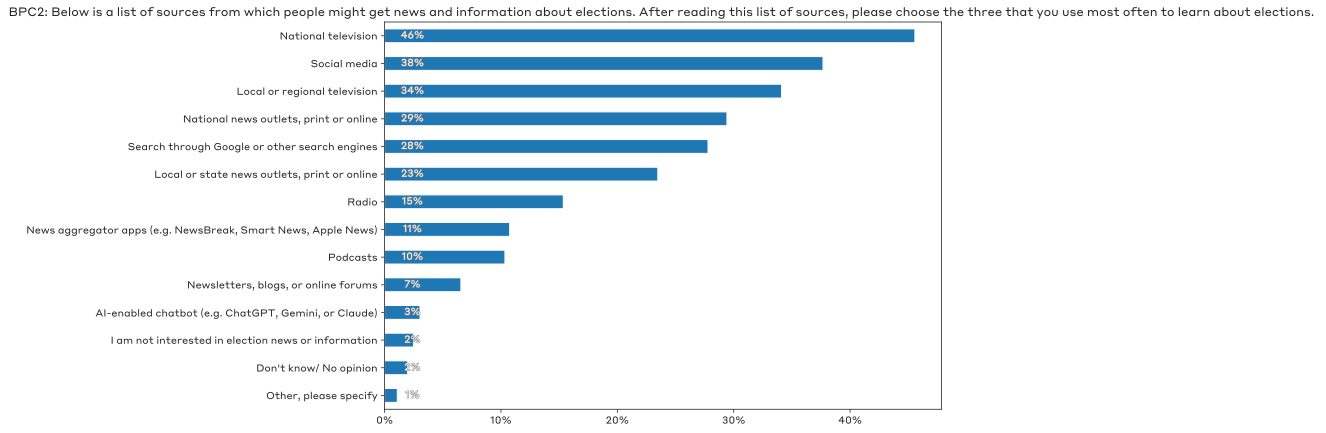

In [12]:
demo = None

questions = [f"BPC{i}" for i in range(1, 3)]

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,demo,suppress_output=False)

,overall
"Other, please specify",0.019646
Civic or religious organizations in your community,0.071087
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",0.081659
Don't know/ No opinion,0.090682
"Your favorite commentator or analyst from a radio show, podcast, TV show, blog, or newspaper",0.090885
"Elected officials at any level (e.g. mayors, governors, Congress members)",0.091285
A national political party organization,0.105214
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",0.107034
Your preferred candidate,0.143831
Election-related organizations (including integrity and voting rights groups),0.150350


,overall
"Other, please specify",0.025688
Civic or religious organizations in your community,0.053657
Don't know/ No opinion,0.078028
Your preferred candidate,0.090816
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",0.098336
A national political party organization,0.113745
"Elected officials at any level (e.g. mayors, governors, Congress members)",0.115943
"Your favorite commentator or analyst from a radio show, podcast, TV show, blog, or newspaper",0.119180
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",0.128820
Local or county administrators,0.157792


,overall
"Other, please specify",0.024127
Civic or religious organizations in your community,0.042359
Don't know/ No opinion,0.056425
"Elected officials at any level (e.g. mayors, governors, Congress members)",0.091592
A national political party organization,0.099445
Your preferred candidate,0.103331
Local or county administrators,0.108214
"Fact-checking organizations (e.g. Snopes, PolitiFact, AP Fact Check, etc.)",0.114741
State election administrators,0.129804
"Your favorite social media influencer or content creator (e.g. TikTok, X/Twitter, Reels, etc.)",0.130675


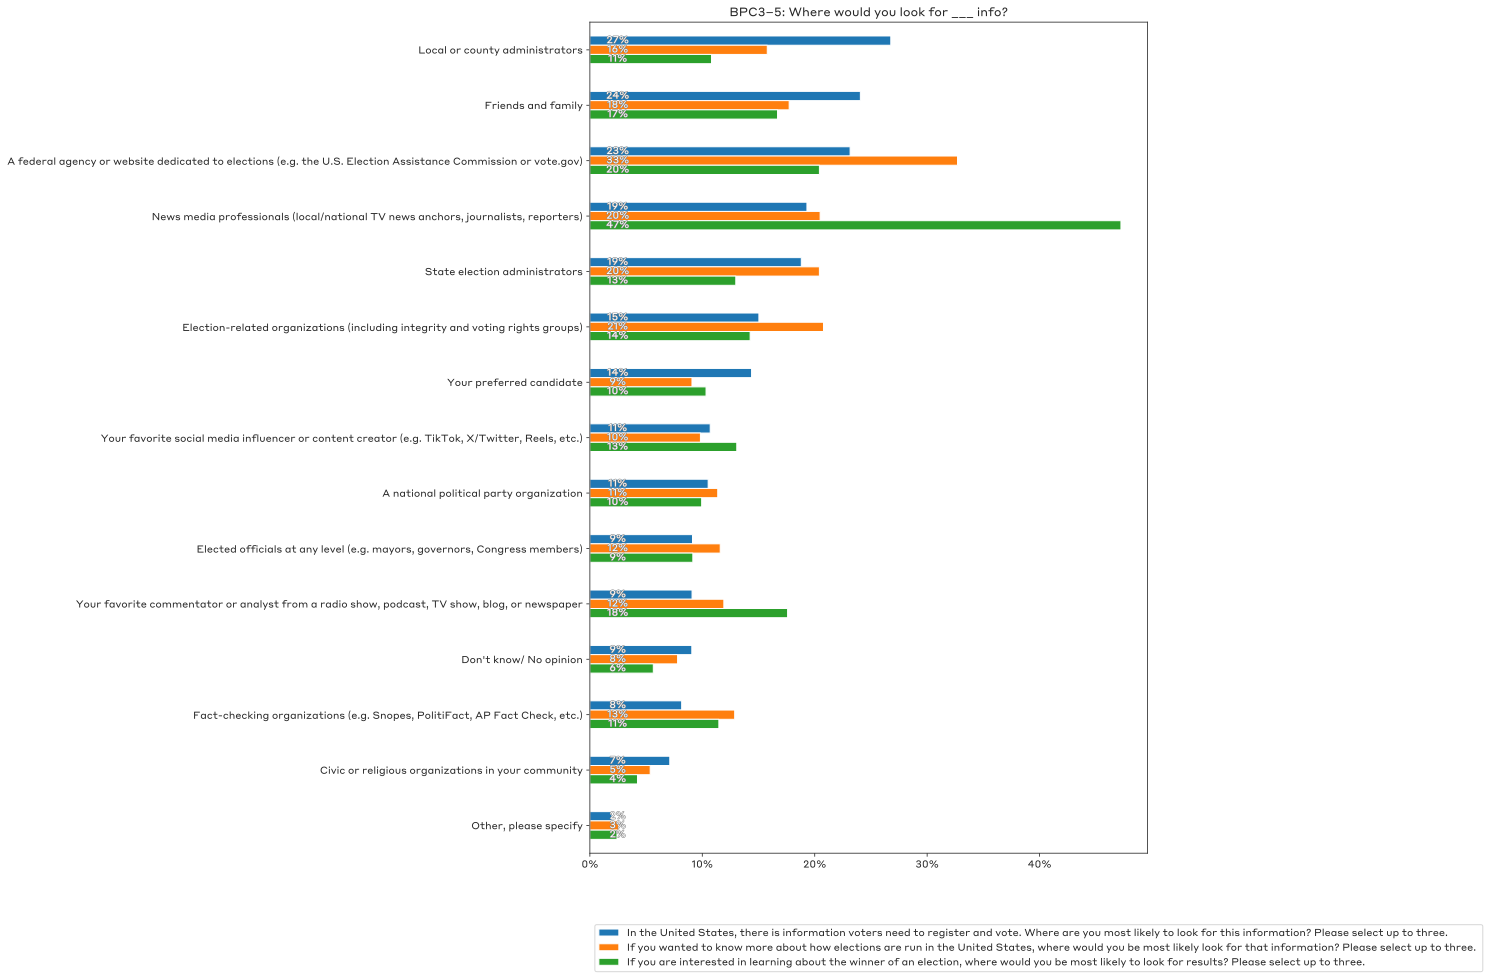

In [13]:
questions = [f"BPC{j}" for j in range(3, 6)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions)
ax = visualizing.plot_question(final_df, 'BPC3–5', 'Where would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("charts/info_topthree.csv")

,overall
Substack,0.002838
Discord,0.005787
Threads,0.008699
Nextdoor,0.012114
WhatsApp,0.021707
Spotify,0.022486
Apple Podcasts,0.023660
Snapchat,0.028518
LinkedIn,0.030923
"Other, please specify",0.038794


,overall
Substack,0.005562
Discord,0.010348
Threads,0.012789
Spotify,0.019648
WhatsApp,0.020655
Apple Podcasts,0.023261
Snapchat,0.025111
Nextdoor,0.025299
Truth Social,0.036429
"Other, please specify",0.036799


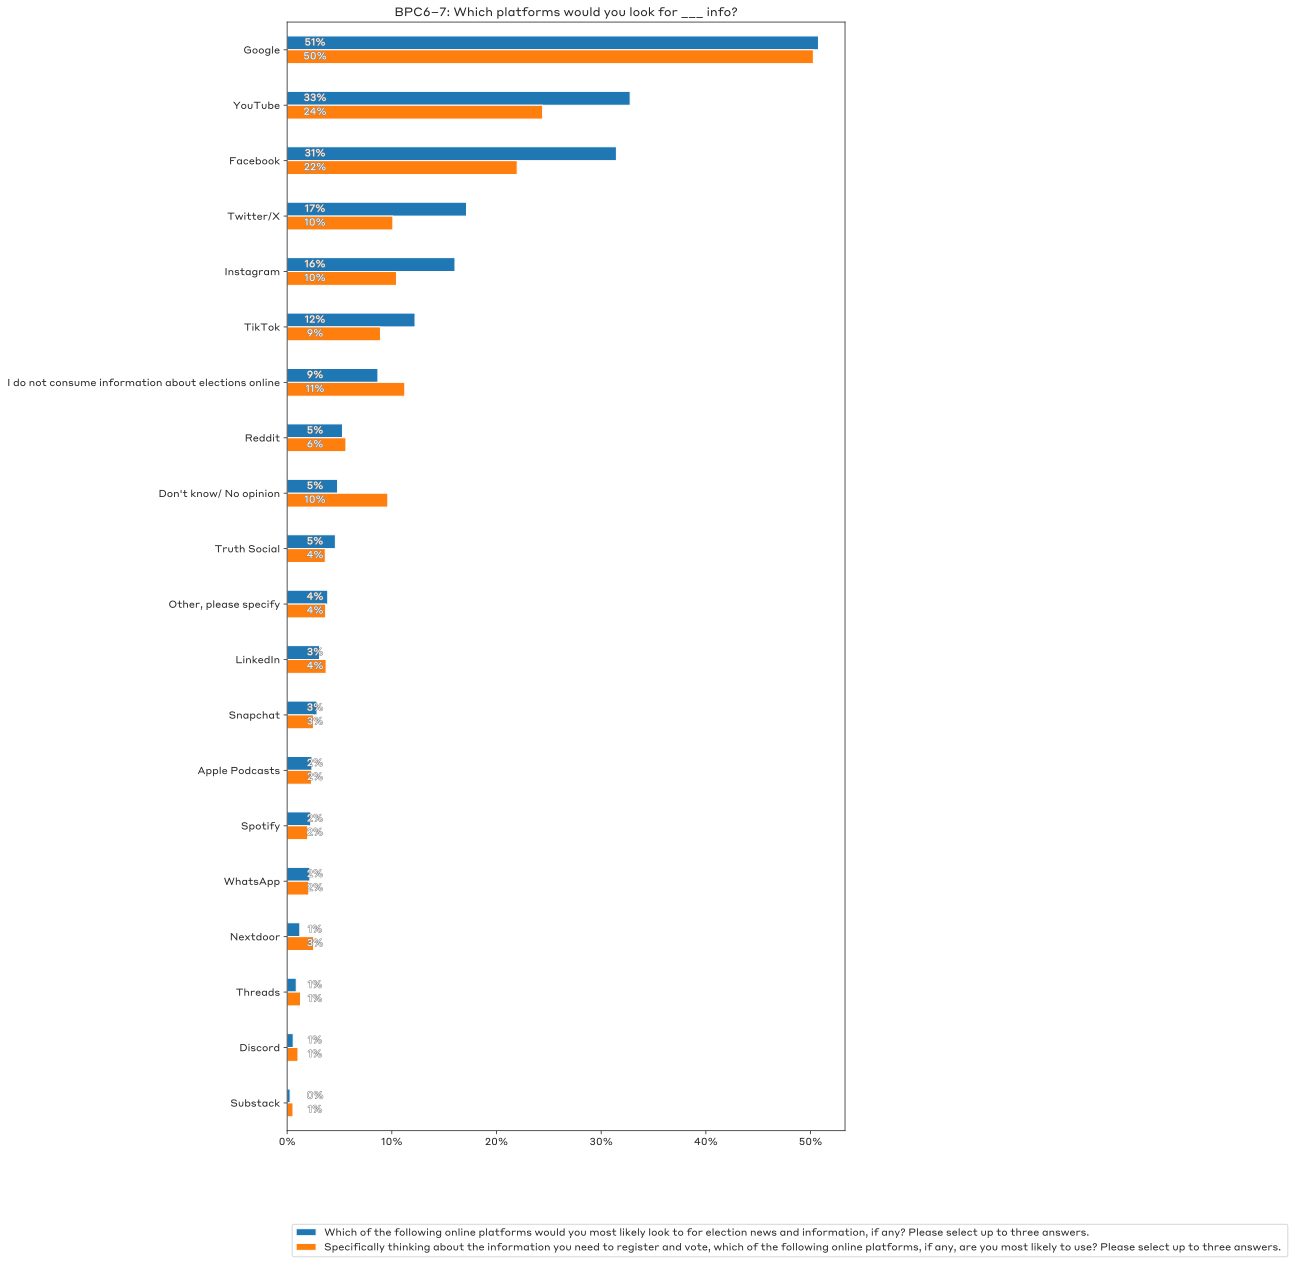

In [14]:
questions = [f"BPC{j}" for j in range(6, 8)]

final_df = mc_processor.get_parallel_questions(data, codebook, q_codebook, questions)

ax = visualizing.plot_question(final_df, 'BPC6–7', 'Which platforms would you look for ___ info?')

final_df = final_df.sort_values(by=final_df.columns[0],ascending=False).map(lambda x: f"{x:.1%}")
# display(final_df)
final_df.to_csv("charts/online_platforms.csv")

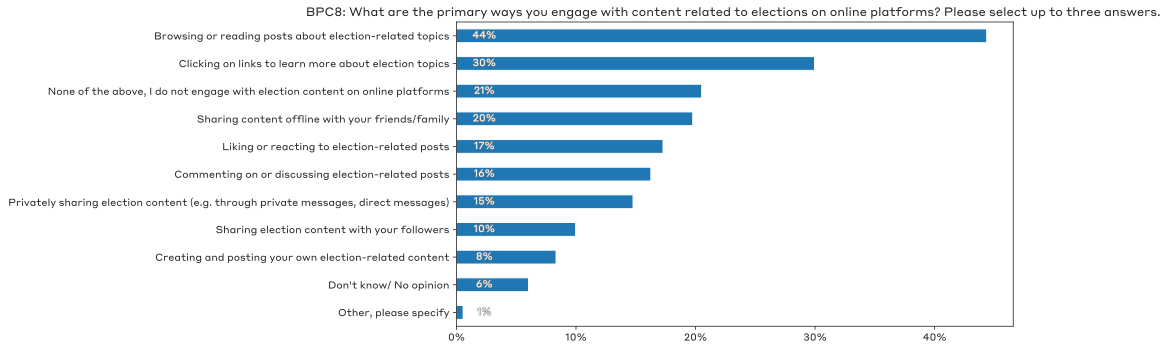

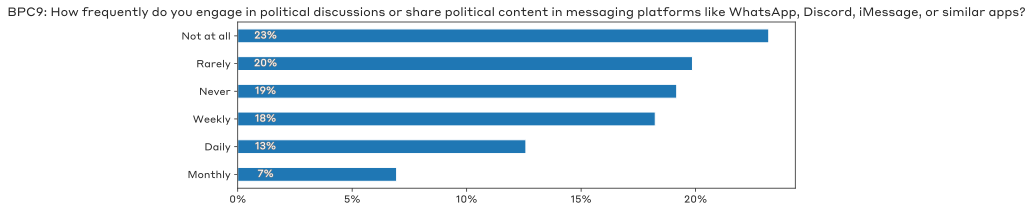

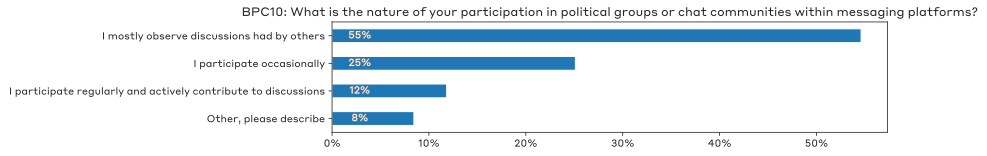

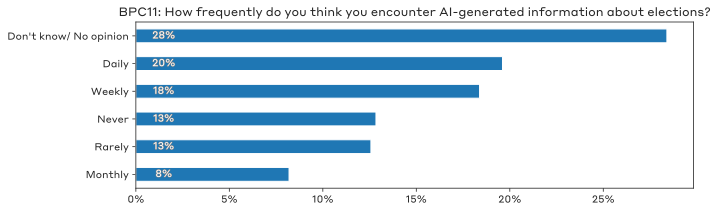

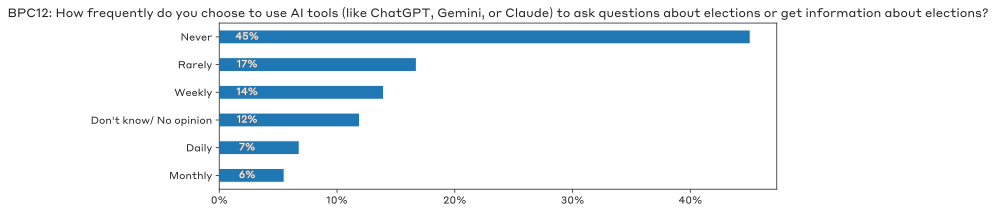

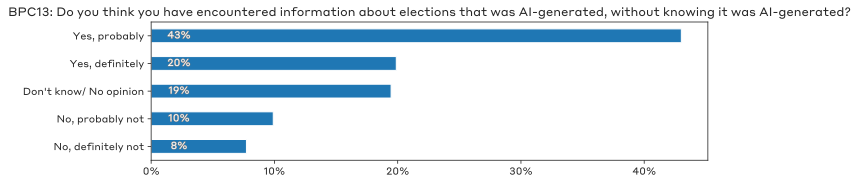

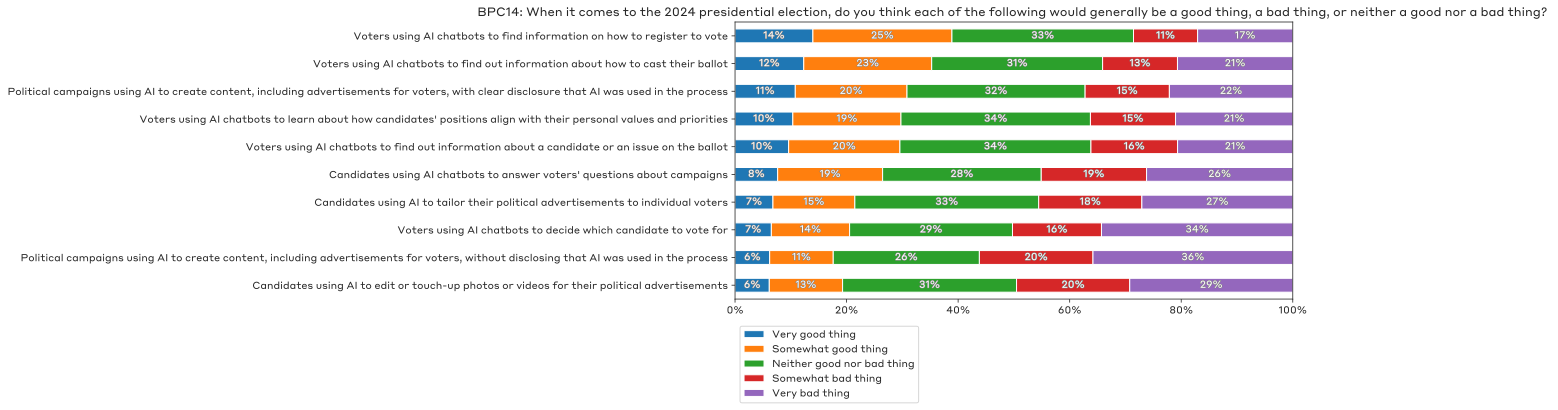

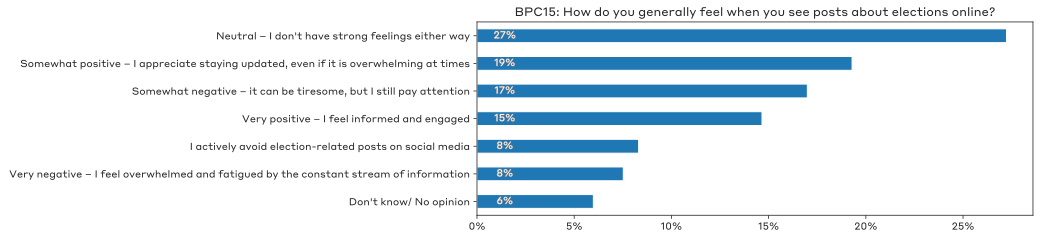

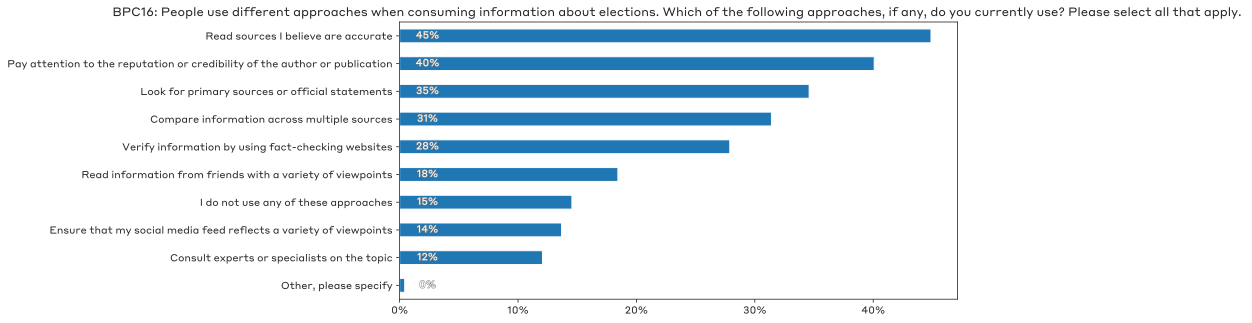

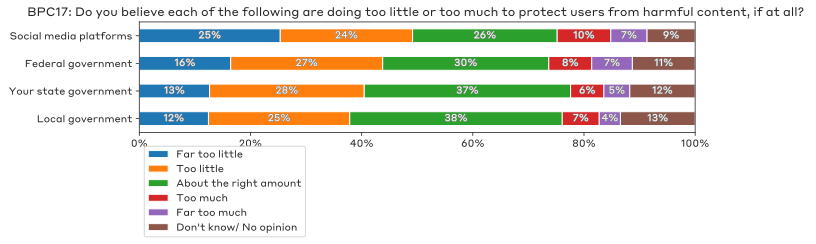

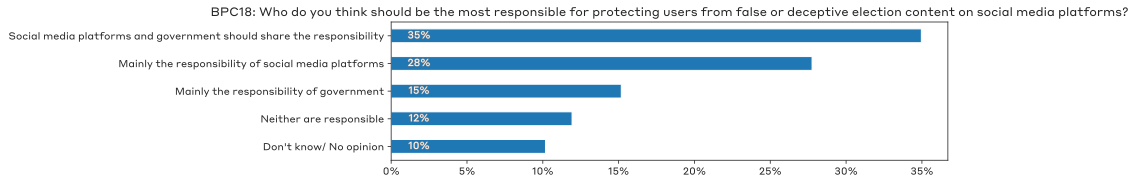

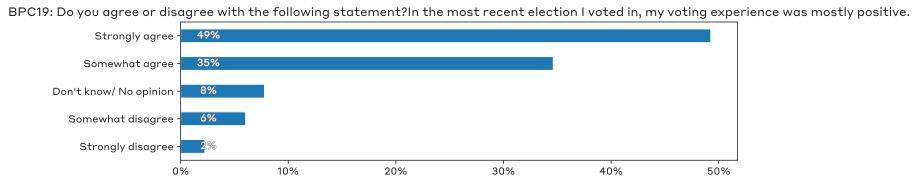

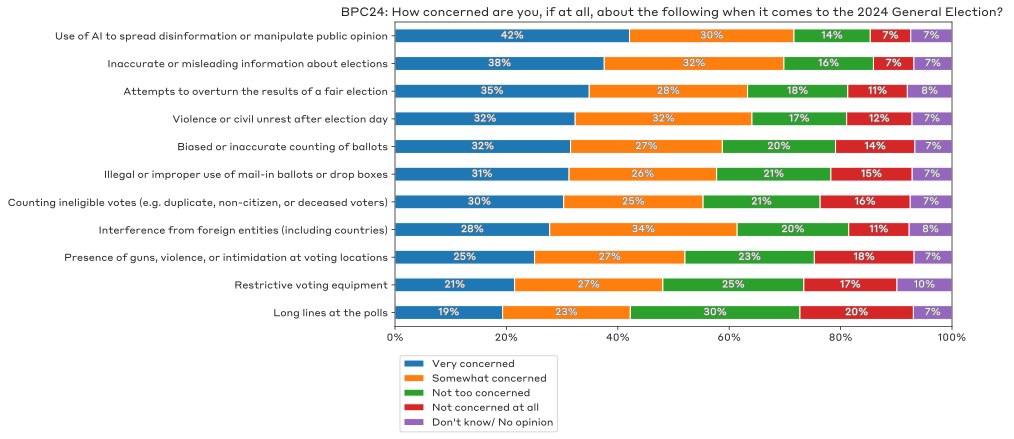

In [15]:
questions = [f"BPC{i}" for i in range(8, 20)] + ['BPC24']

for question in questions:
     df = mc_processor.run_and_display(data,codebook,q_codebook,question,demo,suppress_output=False)


## Single use code / misc

Trans voters' concerns about "Presence of guns, violence, or intimidation at voting locations"

In [108]:
df = mc_processor.run_and_display(data,codebook,q_codebook,"BPC24",demo="BPCxdem2",suppress_output=True)
df = df.T
df = df.xs('Presence of guns, violence, or intimidation at voting locations', level=1).T

In [109]:
df.loc['Not concerned'] = df.loc['Not concerned at all'] + df.loc["Not too concerned"]
df.loc['Concerned'] = df.loc['Somewhat concerned'] + df.loc['Very concerned']

df = df.drop(['Not concerned at all',"Not too concerned",'Somewhat concerned','Very concerned',"Don't know/ No opinion"])

df = df.iloc[::-1]

df

,Identify Trans/Genderqueer/Non-Conforming - Yes,Identify Trans/Genderqueer/Non-Conforming - No
Concerned,0.688969,0.520590
Not concerned,0.288216,0.411338


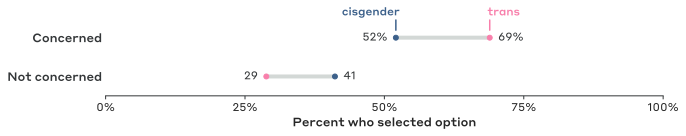

In [110]:
importlib.reload(visualizing)

visualizing.dotplot(df,
                    'charts/trans_concerns.png',
                    start_tick_title = "trans",
                    end_tick_title = "cisgender",
                    xlabel='Percent who selected option',
                    plot_type = "xpid",
                    x_axis_limit=1)

Partisan splits in BPC17: Do you believe each of the following are doing too little or too much to protect users from harmful content, if at all?
Focused on **social media companies**

In [111]:
## DOT PLOT FOR BPC17

res17 = mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo="xpid3",suppress_output=True, sort=False)
res17 = res17.T
res17 = res17.xs('Social media platforms', level=1)

#adding in overall - ultimately should have had it included in mc_processor, not sure why I didn't
res17_overall = mc_processor.run_and_display(data,codebook,q_codebook,"BPC17",demo=None,suppress_output=True, sort=False)
res17.loc["overall"] = res17_overall.loc["Social media platforms"]
# res17 = res17.drop(["Don't know/ No opinion"],axis=1)
res17 = res17.T
res17.to_csv("processed/xpid3/BPC17_social.csv")
res17
res17 = res17[["PID: Rep (no lean)","PID: Dem (no lean)"]]

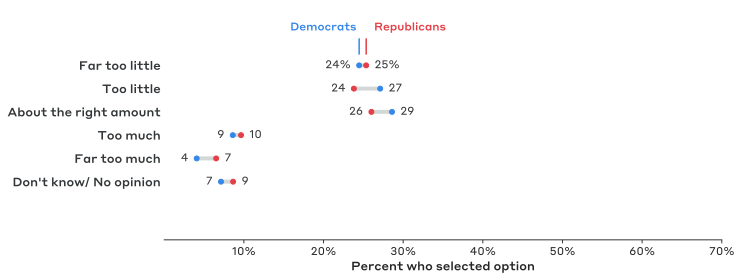

In [112]:
importlib.reload(visualizing)

visualizing.dotplot(res17,
                    'charts/xpid_toomuch.png',
                    start_tick_title = "Republicans",
                    end_tick_title = "Democrats",
                    xlabel='Percent who selected option',
                    plot_type = "xpid",
                    x_axis_limit=.7)